In [1]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from PIL import Image
import anndata as ad
import re

In [ ]:
def normalize(gene_name):
    tumor_score = adata[:,gene_name].X
    tumor_score_normalized = (tumor_score - tumor_score.min()) / (tumor_score.max() - tumor_score.min()+1e-5)
    return tumor_score_normalized
exp_path='./01-data/06-features/TCGA-G3-AAV1-01Z-00-DX1'
coord_path='./01-data/03-coord-added/TCGA-G3-AAV1-01Z-00-DX1_patch_centers.csv'
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0
exp_files=os.listdir(exp_path)
exp=sorted(exp_files,key=extract_number)
num_patch=len(exp)
exp_array=np.zeros((num_patch,183))
for i,file in enumerate(exp):
    with open(os.path.join(exp_path,file).replace('npy','json'),'r') as f:
        single_exp=json.load(f)
    exp_array[i]=single_exp['exp']
adata=ad.AnnData(exp_array)
coord=pd.read_csv(coord_path)
coord.iloc[:,0]=[i.split('/')[-1] for i in coord.iloc[:,0]]
coord.index=coord.iloc[:,0]
spatial_array=np.zeros((num_patch,2))
selected_patch=[i.replace('json','png') for i in exp]
selected_coord=coord.loc[selected_patch]
spatial=np.concatenate((np.array(selected_coord.iloc[:,1]).reshape(num_patch,1),np.array(selected_coord.iloc[:,2]).reshape(num_patch,1)),axis=1)
adata.obsm['spatial']=spatial
gene_path='./01-data/04-Liver/liver_hvg_cut_200_minus3.npy'
gene=list(np.load(gene_path))
adata.var_names=gene
adata.obs.index = adata.obs.index.astype(int)
adata.var_names = adata.var_names.astype(str)
adata.obs_names = adata.obs_names.astype(str)
adata

AnnData object with n_obs × n_vars = 26693 × 183
    obsm: 'spatial'

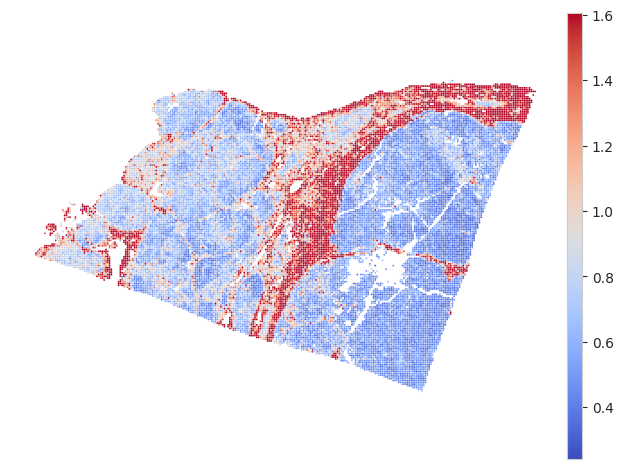

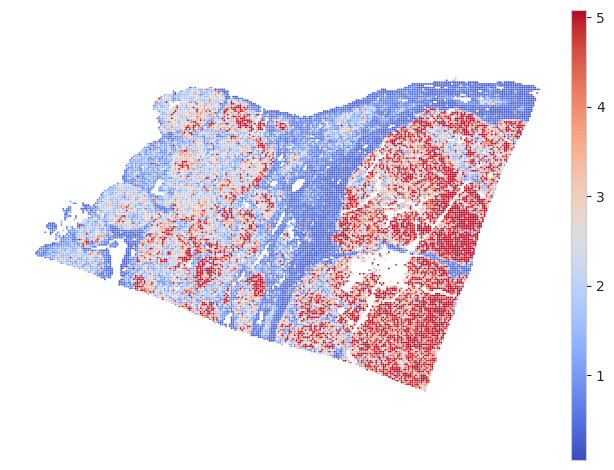

In [ ]:
import matplotlib.pyplot as plt
genes=['SERPINB3','BTF3','GSTA1','GPC3','ACTA2','CD34','PDGFRB','PDPN','HPX']
for gene in genes:
    normalize_value=normalize(gene)
    new_name=gene+'_normalized'
    adata.obs[new_name]=normalize_value
adata.obs['tumor_score']=(adata.obs['SERPINB3_normalized']+adata.obs['HPX_normalized']+adata.obs['GSTA1_normalized'])/3
adata.obs['stromal']=(adata.obs['ACTA2_normalized']+adata.obs['PDGFRB_normalized']+adata.obs['CD34_normalized']+adata.obs['PDPN_normalized'])/4
adata.obs['tumor_tissue']=adata.obs['tumor_score']/adata.obs['stromal']
adata.obs['stromal_tissue']=adata.obs['stromal']/adata.obs['tumor_score']
adata.obs['final']=((adata.obs['tumor_score']*adata.obs['tumor_score'])/(adata.obs['stromal']*adata.obs['stromal']))
sc.pl.spatial(adata, color='stromal_tissue', spot_size=224, cmap='coolwarm',
              vmax=np.percentile(adata.obs['stromal_tissue'], 90), show=False)
plt.gca().axis('off')
plt.title('')
plt.tight_layout()
plt.show()

# final 图
sc.pl.spatial(adata, color='final', spot_size=224, cmap='coolwarm',
              vmax=np.percentile(adata.obs['final'], 85), show=False)
plt.gca().axis('off')
plt.title('')
plt.tight_layout()
plt.show()

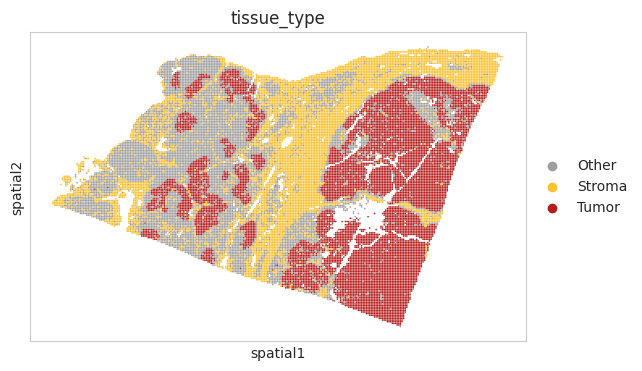

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

final_val=adata.obs['final'].values
stromal_val = adata.obs['stromal_tissue'].values
stromal_thresh = np.percentile(stromal_val, 70)  
stromal_low    = np.percentile(final_val, 10)   
final_thre = np.percentile(final_val,50)
tissue_type = np.full(stromal_val.shape, 'Other', dtype=object)
mask_stroma = (stromal_val >= stromal_thresh)
tissue_type[mask_stroma] = 'Stroma'
mask_tumor =(final_val > final_thre)
tissue_type[mask_tumor] = 'Tumor'
spatial_coords = adata.obsm['spatial']

# 24 neighbours
n_neighbors = 24
nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(spatial_coords)
distances, indices = nbrs.kneighbors(spatial_coords)
neighbor_tumor_fraction_threshold = 0.5
neighbor_stroma_fraction_threshold = 0.3     

for i in range(len(tissue_type)):
    if tissue_type[i] == 'Tumor':
        neighbor_inds = indices[i, 1:]
        tumor_neighbors = np.sum(tissue_type[neighbor_inds] == 'Tumor')
        stroma_neighbors = np.sum(tissue_type[neighbor_inds] == 'Stroma')
        fraction_tumor = tumor_neighbors / n_neighbors
        fraction_stroma = stroma_neighbors / n_neighbors

        if fraction_tumor < neighbor_tumor_fraction_threshold or fraction_stroma > neighbor_stroma_fraction_threshold:
            tissue_type[i] = 'Other'
adata.obs['tissue_type'] = tissue_type
custom_palette = {
    'Tumor': '#B71C1C', 
    'Stroma': '#FBC02D',  
    'Other': '#9E9E9E'   
}
sc.pl.spatial(adata,color='tissue_type',spot_size=224,palette=custom_palette)

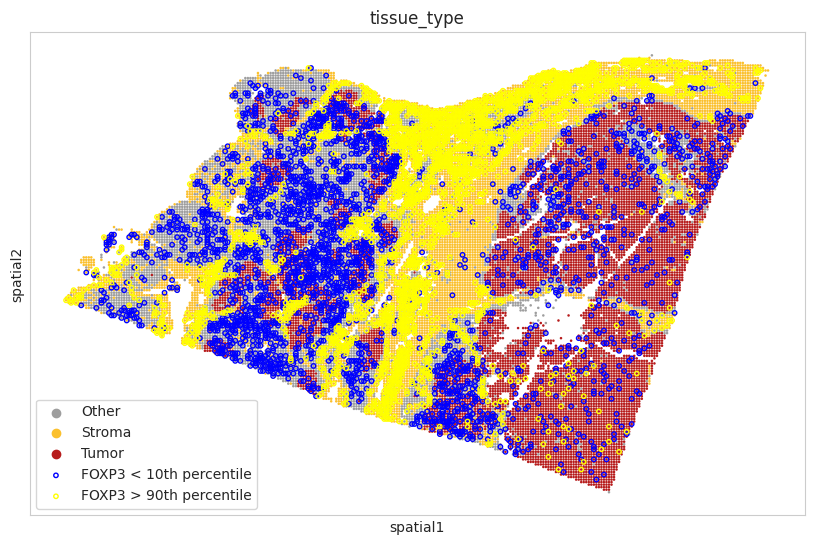

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

foxp3_expr = adata[:, 'FOXP3'].X
if hasattr(foxp3_expr, "toarray"):
    foxp3_expr = foxp3_expr.toarray().flatten()
else:
    foxp3_expr = np.array(foxp3_expr).flatten()

threshold_low = np.percentile(foxp3_expr, 10)
threshold_high = np.percentile(foxp3_expr, 90)

# threshold_high
adata.obs['FOXP3_mask_high'] = (foxp3_expr >threshold_high).astype(int)
adata.obs['FOXP3_mask_low'] = (foxp3_expr < threshold_low).astype(int)

fig, ax = plt.subplots(figsize=(10,10))
sc.pl.spatial(adata, color='tissue_type', cmap='coolwarm',ax=ax, spot_size=224,show=False,vmax=np.percentile(adata.obs['tumor_tissue'],80) )
coords = adata.obsm['spatial']

mask_high = adata.obs['FOXP3_mask_high'] == 1
mask_low = adata.obs['FOXP3_mask_low'] == 1
ax.scatter(coords[mask_low, 0], coords[mask_low, 1],
           s=10, facecolors='none', edgecolors='blue', label='FOXP3 < 10th percentile')
ax.scatter(coords[mask_high, 0], coords[mask_high, 1],
           s=10, facecolors='none', edgecolors='yellow', label='FOXP3 > 90th percentile')

ax.legend()
plt.show()



In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata
adata.obs['foxp3_3d']=normalize('FOXP3')
coords = adata.obsm['spatial']  
x = coords[:, 0]
y = coords[:, 1]
gene_expr = adata.obs['foxp3_3d']
if hasattr(gene_expr, "toarray"):
    gene_expr = gene_expr.toarray().flatten()
else:
    gene_expr = np.array(gene_expr).flatten()
z = gene_expr
grid_x, grid_y = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
grid_z[grid_z > 1] = np.nan
fig = go.Figure(data=[go.Surface(
    z=grid_z,
    x=-grid_x,
    y=grid_y,
    colorscale='RdBu_r',
    cmin=np.percentile(grid_z[~np.isnan(grid_z)], 2),  
    cmax=np.percentile(grid_z[~np.isnan(grid_z)], 98),
    showscale=True
)])

fig.update_layout(
    title='Interactive 3D FOXP3 Expression (Trimmed)',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='FOXP3 Expression'
    ),
    autosize=True,
    height=700
)
fig.update_layout(
    title=None,  
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        bgcolor='rgba(0,0,0,0)', 
    ),
    margin=dict(l=0, r=0, t=0, b=0),  
    paper_bgcolor='rgba(0,0,0,0)',   
    plot_bgcolor='rgba(0,0,0,0)',    
    height=700
)
fig.show()

